In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
%cd /content/MyDrive/MyDrive

/content/MyDrive/MyDrive


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Raw Dataset Directory
train_data = pathlib.Path('./flower_dataset/training')
val_data = pathlib.Path('./flower_dataset/validation')
test_data = pathlib.Path("./flower_dataset/testing")

training_image_count = len(list(train_data.glob('*/*.jpg')))
validation_image_count = len(list(val_data.glob('*/*.jpg')))
testing_image_count = len(list(test_data.glob('*/*.jpg')))

# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in train_data.glob('*') ])

# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

# Shape of inputs to NN Model
BATCH_SIZE = 32            # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 224           # input Shape required by the model
IMG_WIDTH = 224             # input Shape required by the model
STEPS_PER_EPOCH = np.ceil(training_image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(validation_image_count/BATCH_SIZE)
TESTING_STEPS = np.ceil(testing_image_count/BATCH_SIZE)

# Rescalingthe pixel values from 0~255 to 0~1 For RGB Channels of the image.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# training_data for model training
train_data_gen = image_generator.flow_from_directory(directory=str(train_data),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), # Resizing the raw dataset
                                                     class_mode='categorical')

# validation data for model training
validation_data_gen = image_generator.flow_from_directory(directory=str(val_data),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), # Resizing the raw dataset
                                                     class_mode='categorical')

# testing data for model training
testing_data_gen = image_generator.flow_from_directory(directory=str(test_data),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), # Resizing the raw dataset
                                                     class_mode='categorical')

5
Found 3457 images belonging to 5 classes.
Found 843 images belonging to 5 classes.
Found 17 images belonging to 5 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Dropout

# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the number of classes in your dataset
num_classes = 5

# Reduce regularization and add more complexity
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Reduce dropout rate
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  # 5 classes for emotions

model = Model(inputs=base_model.input, outputs=output)

# Adjust learning rate
from tensorflow.keras.optimizers import Adam

custom_optimizer = Adam(learning_rate=0.0001)  # Experiment with different learning rates

model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [8]:
# callbacks at training
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("accuracy")==1.00 and logs.get("loss")<0.03):
            print("\nReached 100% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

# Implement early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate during training
learning_rate_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# TensorBoard.dev Visuals
log_dir="ResNet/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
# Training the Model
history = model.fit(
      train_data_gen,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=50,
      validation_data=validation_data_gen,
      validation_steps=VALIDATION_STEPS,
      callbacks=[tensorboard_callback, early_stopping_callback])

# Saving the model
model.save('ResNet/ResNet_trained_model/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/')

Epoch 1/50
109/109 [==============================] - 3133s 28s/step - loss: 0.5800 - accuracy: 0.7776 - val_loss: 2.2476 - val_accuracy: 0.2444
Epoch 2/50
109/109 [==============================] - 47s 428ms/step - loss: 0.1955 - accuracy: 0.9387 - val_loss: 3.2268 - val_accuracy: 0.2444
Epoch 3/50
109/109 [==============================] - 47s 433ms/step - loss: 0.1031 - accuracy: 0.9659 - val_loss: 2.5145 - val_accuracy: 0.2444
Epoch 4/50
109/109 [==============================] - 48s 441ms/step - loss: 0.0691 - accuracy: 0.9783 - val_loss: 1.8341 - val_accuracy: 0.3903
Epoch 5/50
109/109 [==============================] - 48s 440ms/step - loss: 0.0629 - accuracy: 0.9798 - val_loss: 2.3874 - val_accuracy: 0.3903
Epoch 6/50
109/109 [==============================] - 48s 441ms/step - loss: 0.0515 - accuracy: 0.9847 - val_loss: 1.8018 - val_accuracy: 0.5670
Epoch 7/50
109/109 [==============================] - 48s 437ms/step - loss: 0.0832 - accuracy: 0.9740 - val_loss: 0.7235 - val_ac

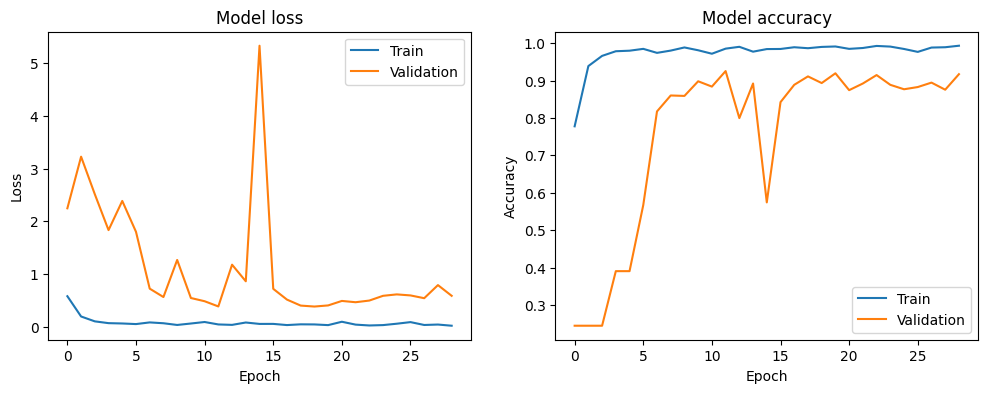

In [10]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

In [11]:
model.evaluate(testing_data_gen)

1/1 [==============================] - 1s 1s/step - loss: 0.0843 - accuracy: 0.9412


[0.08426660299301147, 0.9411764740943909]

In [12]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir ResNet/logs/20230929-060531 --port=8019

<IPython.core.display.Javascript object>

In [15]:
new_model = tf.keras.models.load_model('ResNet/ResNet_trained_model/20230929-181800')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [17]:
# Save the trained model in the native Keras format (.h5)
model.save('./ResNet/model.h5')